In [2]:
## imports
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.tsa.ar_model
from sklearn.metrics import mean_squared_error
import numpy as np
from math import sqrt

In [3]:
## loading and reading in csv dataset using pandas
brazil_df = pd.read_csv('brazil_covid19_revised.csv')
brazil_df.head()

,date,region,state,cases,newCases,deaths
0,3/7/20,Centro-Oeste,Distrito Federal,1,1,0
1,3/8/20,Centro-Oeste,Distrito Federal,1,0,0
2,3/9/20,Centro-Oeste,Distrito Federal,1,0,0
3,3/10/20,Centro-Oeste,Distrito Federal,1,0,0
4,3/11/20,Centro-Oeste,Distrito Federal,2,1,0


In [4]:
brazil_df[brazil_df['date'] == '5/14/20']['cases'].sum()

202918

In [5]:
brazil_df['date'] = pd.to_datetime(brazil_df['date'])
brazil_df

,date,region,state,cases,newCases,deaths
0,2020-03-07,Centro-Oeste,Distrito Federal,1,1,0
1,2020-03-08,Centro-Oeste,Distrito Federal,1,0,0
2,2020-03-09,Centro-Oeste,Distrito Federal,1,0,0
3,2020-03-10,Centro-Oeste,Distrito Federal,1,0,0
4,2020-03-11,Centro-Oeste,Distrito Federal,2,1,0
5,2020-03-12,Centro-Oeste,Distrito Federal,2,0,0
6,2020-03-13,Centro-Oeste,Distrito Federal,2,0,0
7,2020-03-14,Centro-Oeste,Distrito Federal,6,4,0
8,2020-03-15,Centro-Oeste,Distrito Federal,8,2,0
9,2020-03-16,Centro-Oeste,Distrito Federal,13,5,0


In [6]:
brazil_df_sort = brazil_df.sort_values(by = 'date')

In [7]:
date_cases = {}
date_cases_keys = brazil_df_sort['date']
final_keys = []
for date in date_cases_keys:
    if date not in final_keys:
        final_keys.append(date)
date_cases_values = []

test_d = '2/24/20'

for d in date_cases_keys:
    if d != test_d:
        value = brazil_df_sort[brazil_df_sort['date'] == d]['cases'].sum()
        date_cases_values.append(value)
        test_d = d


In [8]:
date_cases = {final_keys[i]: date_cases_values[i] for i in range(len(final_keys))} 
date_case = pd.DataFrame.from_dict(date_cases, orient= 'index', columns = ['Cases'])

In [9]:
brazil_df_sort['date'] = pd.to_datetime(brazil_df_sort['date'])

In [10]:
dates_list = []
for date in brazil_df_sort['date']:
    if date not in dates_list:
        dates_list.append(date)
date_cases_2 = {dates_list[i]: date_cases_values[i] for i in range(len(dates_list))} 
date_case_2 = pd.DataFrame.from_dict(date_cases_2, orient= 'index', columns = ['Cases'])

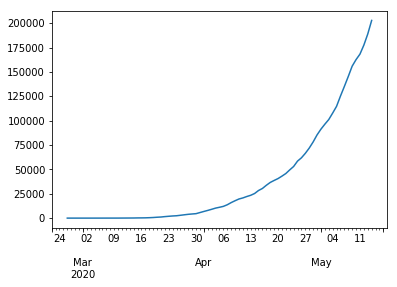

In [11]:
date_case_2['Cases'].plot()
plt.show()

In [12]:
## Determining rolling statistics - stationarety
rolmean = date_case_2.rolling(window= 12).mean()
rolstd = date_case_2.rolling(window=12).std()

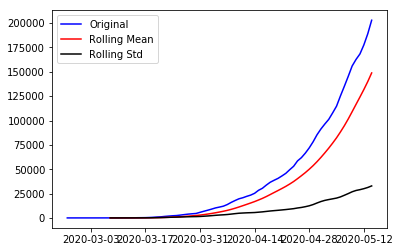

In [13]:
## plot rolling statistics
orig = plt.plot(date_case_2, color = 'blue', label= "Original")
mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = "Rolling Std")
plt.legend(loc = 'best')
plt.show(block = False)
## mean and std not constant - so not stationary

In [14]:
## Perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

print("Results of Dickey-Fuller Test")
test = adfuller(date_case_2['Cases'], autolag = "AIC")

output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for k,v in test[4].items():
    output['Critical Value (%s)'%k] = v
    
print(output)

##cannot reject null hypothesis - not stationary

Results of Dickey-Fuller Test
Test Statistic                  1.425208
p-value                         0.997226
#Lags Used                      7.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [102]:
def est_trend(data, n):
    ##Estimating Trend
    data_est = np.log(data)

    
    ##calculating moving averages

    movingAvg = data_est.rolling(window=12).mean()
    movingStd = data_est.rolling(window = 12).std()
    
    #fig, axs = plt.subplots(3)
    
    plt.figure(1)
    plt.plot(data_est)
    plt.plot(movingAvg, color = 'red')
    
    ##diff between moving averages and actual cases
    diff = data_est - movingAvg
    ##remove null values
    diff.dropna(inplace = True)
    
    plt.figure(2)
    plt.plot(diff)
    plt.plot(movingAvg, color = 'red', label = 'MovingAvg')
    plt.plot(movingStd, color = 'black', label = 'MovingStd')
    

    ##reperform Dickey-Fuller Test on transformed data to check stationarity
    print("Results of Dickey-Fuller Test")
    test = adfuller(data_est['Cases'], autolag = "AIC")

    output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for k,v in test[4].items():
        output['Critical Value (%s)'%k] = v
    
    print(output)
    
    ##calculate weighted average
    weight_avg = data_est.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
    
    ##exponentiate to reverse log transformation (e^x)
    data_est = np.exp(data_est)
    
    ## prediction 
    
   
    from statsmodels.tsa.ar_model import AR
    from sklearn.metrics import r2_score

    ##split data into train and test
    X = data_est.dropna()
    n = int(np.floor(0.2 * len(X)))
    train = X[1: len(X) - n]
    test = X[len(X) - n:]
    
    ##fit and train model using split data
    model = AR(train)
    model_fitted = model.fit()
    print('the lag value is: %s' % model_fitted.k_ar)
    
    predict = model_fitted.predict(start = len(train), end = len(train) + len(test) - 1, dynamic = False)
    ##print(predict)

    ##plot predicted data vs. true/observed data
    plt.figure(3)
    plt.title("Predicted vs. Observed Cases")
    plt.legend()
    plt.plot(data_est, color = 'blue')
    plt.plot(predict, color = 'red')
    
    ## error analysis - try a few different methods
    
    #r^2 error analysis - not metric to show if model is a good future predictor, but shows if model is good fit to 
    #observed data
    r2_err = r2_score(data_est.tail(n), predict)
    print('R^2 error: %s' % r2_err)
    
    #mean absolute error - measuring prediction errors because prediction in same unit as original (avg forecast error)
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(data_est.tail(n), predict)
    print('Mean Absolute Error: %s' % mae)
    
    #root mean squared error - sqrt average of square of forecase error (mse): basically same as mse but when dealing
    #with prediction in same unit as original - how concentrated is data around line of best fit
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(predict, data_est.tail(n))
    print('Mean squared error: %s' % mse)
    
    rmse = np.sqrt(mse)
    print('Root mean squared error: %s' % rmse)

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
No handles with labels found to put in legend.


Results of Dickey-Fuller Test
Test Statistic                 -3.428922
p-value                         0.010012
#Lags Used                      8.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64
the lag value is: 11
R^2 error: 0.8046865137004747
Mean Absolute Error: 12078.372574810026
Mean squared error: 259678994.6884428
Root mean squared error: 16114.558470167365


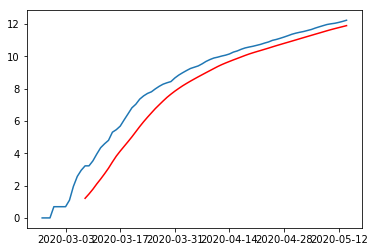

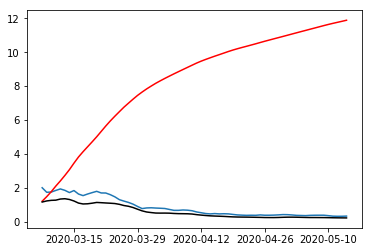

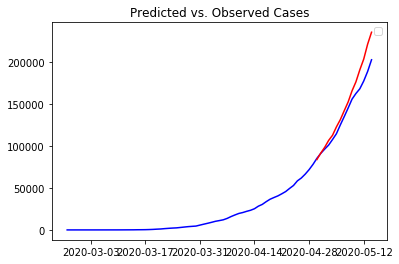

In [103]:
est_trend(date_case_2, 40)

In [17]:
def test_stationarity(data):
    movingAverage = data.rolling(window=12).mean()
    movingStd = data.rolling(window=12).std()
    plt.plot(data)
    plt.plot(movingAverage, color = 'red')
    plt.plot(movingStd, color = 'black')
    
    print("Results of Dickey-Fuller Test")
    test = adfuller(data['Cases'], autolag = "AIC")

    output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for k,v in test[4].items():
        output['Critical Value (%s)'%k] = v
    
    print(output)

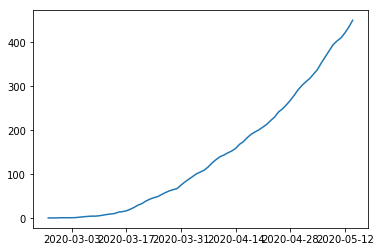

In [20]:
date_case_2_sqrt = np.sqrt(date_case_2)
plt.plot(date_case_2_sqrt)

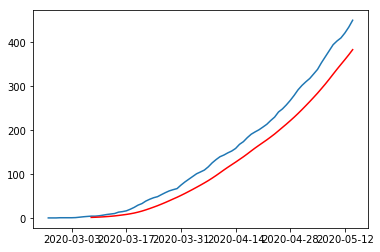

In [21]:
movingAverage2 = date_case_2_sqrt.rolling(window=12).mean()
movingStd2 = date_case_2_sqrt.rolling(window=12).std()
plt.plot(date_case_2_sqrt)
plt.plot(movingAverage2, color = 'red')

In [22]:
minusMovAvg2 = date_case_2_sqrt - movingAverage2
minusMovAvg2.head(12)

##remove null values
minusMovAvg2.dropna(inplace = True)
minusMovAvg2.head(10)

,Cases
2020-03-08,2.833408
2020-03-09,2.500074
2020-03-10,2.928447
2020-03-11,3.791006
2020-03-12,4.741472
2020-03-13,5.158896
2020-03-14,5.460585
2020-03-15,7.542060
2020-03-16,7.566566
2020-03-17,8.127149


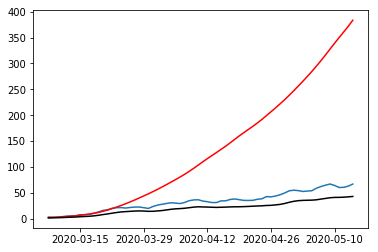

In [23]:
plt.plot(minusMovAvg2)
plt.plot(movingAverage2, color = 'red', label = 'RollingMean')
plt.plot(movingStd2, color = 'black', label = 'RollingStd')
plt.show()

In [24]:
print("Results of Dickey-Fuller Test")
test = adfuller(date_case_2_sqrt['Cases'], autolag = "AIC")

output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for k,v in test[4].items():
    output['Critical Value (%s)'%k] = v
    
print(output)

Results of Dickey-Fuller Test
Test Statistic                  4.616363
p-value                         1.000000
#Lags Used                      3.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


In [25]:
weight_avg2 = date_case_2_sqrt.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
##plt.plot(date_case_2_sqrt)
##plt.plot(weight_avg2, color = 'red')
##test_stationarity(date_case_2_sqrt)

In [74]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score

def orig_pred(data):

    Y = data
    n = int(np.floor(0.2 * len(Y)))
    train = Y[1: len(Y) - n]
    test = Y[len(Y) - n:]

    model = AR(train)
    model_fitted = model.fit()
    print('the lag value is: %s' % model_fitted.k_ar)

    predict = model_fitted.predict(start = len(train), end = len(train) + len(test) - 1, dynamic = False)
    print(predict)

    plt.plot(data)
    plt.title("Original Data Prediction (No Transformation)")
    plt.plot(predict, color = 'red')

    r2_err = r2_score(data.tail(n), predict)
    print('R^2 error: %s' % r2_err)
    
    #mean absolute error - measuring prediction errors because prediction in same unit as original (avg forecast error)
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(data.tail(n), predict)
    print('Mean Absolute Error: %s' % mae)
    
    #root mean squared error - sqrt average of square of forecase error (mse): basically same as mse but when dealing
    #with prediction in same unit as original - how concentrated is data around line of best fit
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(predict, data.tail(n))
    print('Mean squared error: %s' % mse)
    
    rmse = np.sqrt(mse)
    print('Root mean squared error: %s' % rmse)

the lag value is: 11
2020-04-30     83988.143422
2020-05-01     91713.752469
2020-05-02     98520.960869
2020-05-03    106695.176971
2020-05-04    112856.363620
2020-05-05    122852.153796
2020-05-06    131516.682967
2020-05-07    142132.600539
2020-05-08    152542.906867
2020-05-09    165805.394559
2020-05-10    176604.712290
2020-05-11    190960.713419
2020-05-12    203734.492186
2020-05-13    221517.851607
2020-05-14    235768.969884
Freq: D, dtype: float64
R^2 error: 0.8046865137011097
Mean Absolute Error: 12078.372574789291
Mean squared error: 259678994.68759868
Root mean squared error: 16114.558470141175


/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


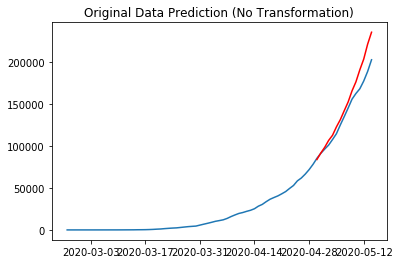

In [75]:
orig_pred(date_case_2)

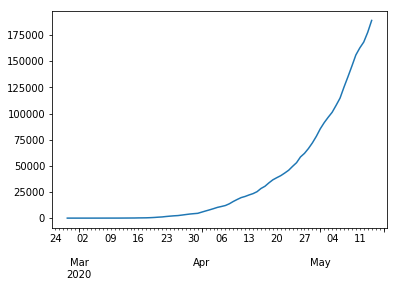

In [30]:
##differencing 
date_case_2['CasesDiff'] = date_case_2['Cases'] = date_case_2['Cases'].shift(1)
date_case_2['CasesDiff'].dropna().plot()